# SNe "Simulations" from NIR data

In [122]:
import snpy
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import scipy
import george

import os
import glob
import itertools

%config InlineBackend.figure_format = 'retina'
print(f'SNooPy version: v{snpy.__version__}')

SNooPy version: v2.6.0


### Auxiliar Functions

In [2]:
def combinations(iterable, r):
    '''Returns all possible combinations without permutation.
    
    **Note:** the output should be inserted in a list
    
    Parameters
    ==========
    iterable: list-like
        List of items from which the combination is computed.
    r: int
        Numbers of items for the combination.
        
    Returns
    =======
    comb_list: list
        List with all combinations.
    '''
    
    comb_list = list(itertools.combinations(iterable, r))
    
    return comb_list            
            
def mag2flux(mag, zp, mag_err=0.0):
    """Converts magnitudes to fluxes, propagating errors if given.
    
    Parameters
    ----------
    mag : array
        Array of magnitudes.
    zp : float or array
        Zero points.
    mag_err : array, default ``0.0``
        Array of magnitude errors.
        
    Returns
    -------
    flux : array
        Magnitudes converted to fluxes.
    flux_err : array
        Magnitude errors converted to errors in fluxes.
    """

    flux = 10**( -0.4*(mag-zp) )
    flux_err =  np.abs( flux*0.4*np.log(10)*mag_err )

    return flux, flux_err

### "Simulations" functions

In [3]:
def update_sn(sn, update_dict):
    """Updates the data of a SN (mjd, flux, mag, etc.).
    
    Parameters
    ==========
    sn: SNooPy object
        SN in a SNooPy object.
    update_dict: dict
        Dictionary with new SN data with bands as keys and sub-dictionaries
        as values. Each sub-dictionary must have `mjd`, `mag` and `mag_err` 
        as keys and their respective values.
        
    Returns
    =======
    sn: SNooPy object
        Updated SN.
    """
    
    for band, data_dict in update_dict.items():

        mjd = data_dict['mjd']
        mag, mag_err = data_dict['mag'], data_dict['mag_err']
        
        sn.data[band].MJD = mjd
        sn.data[band].magnitude = mag
        sn.data[band].mag = mag
        sn.data[band].e_mag = mag_err

        zp = sn.data[band].filter.zp
        flux, flux_err = mag2flux(mag, zp, mag_err)

        # there are some hidden parameters like "_flux" and "_eflux"
        # which are used by other internal functions
        sn.data[band].flux = flux
        sn.data[band]._flux = flux
        sn.data[band].e_flux = flux_err
        sn.data[band]._eflux = flux_err

        # not sure if these are completely necessary, but just in case...
        sn.data[band].sids = np.zeros_like(flux)
        sn.data[band].__dict__['mask'] = np.array([True]*len(flux))
        
    return sn

def filter_coeval_NIRdata(sn):
    """Filters out NIR data of a SNooPy object that does not have 
    coeval J/Jrc2 and H data.
    
    Parameters
    ==========
    sn: SNooPy object
        SN in a SNooPy object.
        
    Returns
    =======
    The updated sn.
    """
    
    # NIR bands labels
    NIR_bands = [band for band in sn.allbands() if band in ['J', 'Jrc2', 'H']]
    NIR_ebands = [f'e_{band}' for band in NIR_bands]  # for errors

    # Find epochs with coeval J and H bands
    # I HAVE TO THINK ON HOW THIS AFFECTS SNe WITH J AND Jrc2 DATA
    sn_df = pd.DataFrame(sn.get_mag_table())
    sn_df.replace(99.900000, np.nan, inplace=True)
    sn_df = sn_df[['MJD'] + NIR_bands + NIR_ebands].dropna()

    # update SN J and H bands data
    NIR_dict = {band:None for band in NIR_bands}
    for band, eband in zip(NIR_bands, NIR_ebands):

        mjd = sn_df['MJD'].values
        mag, mag_err = sn_df[band].values, sn_df[eband].values
        NIR_dict[band] = {'mjd':mjd, 'mag':mag, 'mag_err':mag_err}
        
    sn = update_sn(sn, NIR_dict)        
    return sn

def extract_combinatories(values, n_epochs):
    """Extracts a list of all the combinatories of `values` with 
    `n_epochs` number of items each.
    
    Parameters
    ==========
    values: list-like
        List of values from which the combinatories are extracted.
    n_epochs: int
        Number of items per combinatory.
        
    Returns
    =======
    list_alt_values: list
        List of all the combinatories, where each combinatory is a numpy array.
    """
    
    comb_values_tuples = combinations(values, n_epochs)
    list_comb_values = [np.array(tup) for tup in comb_values_tuples]

    return list_comb_values

def extract_combinatories_dict(sn, n_epochs):
    """Extracts a dictionary with all the combinatories of `mjd`, `mag` and `mag_err`
    for a SN in J/Jrc2 and H bands.
    
    Parameters
    ==========
    sn: SNooPy object
        SN in a SNooPy object.
    n_epochs: int
        Number of items per combinatory.
        
    Returns
    =======
    NIR_dict: dict
        Dictionary with the NIR bands as keys and sub-dictionaries as values.
        Each sub-dictionary has `mjd`, `mag` and `mag_err` as keys and a list
        of combinatories (the results of `alternate_values()`) as values.
    """
    
    # NIR bands labels
    NIR_bands = [band for band in sn.allbands() if band in ['J', 'Jrc2', 'H']]
    NIR_dict = {band:None for band in NIR_bands}
    
    for band in NIR_bands:

        mjd = sn.data[band].MJD.copy()
        mag = sn.data[band].magnitude.copy()
        mag_err = sn.data[band].e_mag.copy()
        
        mjd_list = extract_combinatories(mjd, n_epochs)
        mag_list = extract_combinatories(mag, n_epochs)
        mag_err_list = extract_combinatories(mag_err, n_epochs)
        
        NIR_dict[band] = {'mjd':mjd_list, 'mag':mag_list, 'mag_err':mag_err_list}
        
    return NIR_dict

def calculate_metrics(sn, NIR_band, n_epochs):
    """Calculates the metrics for the NIR bands of a SN.
    
    Parameters
    ==========
    sn: SNooPy object
        SN in a SNooPy object.
    NIR_band: str
        NIR bands. E.g., `J`, `Jrc2` or `H`.
    n_epochs: int
        Number of epochs per NIR band.
        
    Returns
    =======
    m1, m2, m3: ints
        Metrics:- m1 is the phase of the closest epoch to T.max.
                - m2 is the phase of the phases.
                - m3 is the difference between the first and last epoch.
        **Note:** m2 is only calculated if n_epochs >= 2, and m3 if n_epochs == 3.
    """

    assert n_epochs<=3, 'Metrics are only calculated for `n_epochs` <= 3'
    phases = sn.data[NIR_band].MJD - sn.Tmax

    if n_epochs==1:
        m1 = phases[0]
        
        return m1

    elif n_epochs==2:
        m1_ind = np.argmin(np.abs(phases))
        m1 = phases[m1_ind]
        
        m2 = np.mean(phases)
        
        return m1, m2

    elif n_epochs==3:
        m1_ind = np.argmin(np.abs(phases))
        m1 = phases[m1_ind]

        m2 = np.mean(phases)
        m3 = phases[-1] - phases[0]
        
        return m1, m2, m3
    
def fit_combinatory(sn, n_epochs):
    """Fit a SN multiple times for all the combinatories given by `n_epochs`.
    
    Parameters
    ==========
    sn: SNooPy object
        SN in a SNooPy object.
    n_epochs: int
        Number of items per combinatory.
    """
    
    sn = filter_coeval_NIRdata(sn)
    # extract dictionary with all the combinatory for the NIR bands
    comb_dict = extract_combinatories_dict(sn, n_epochs)
    
    NIR_bands = list(comb_dict.keys())
    num_comb = len(comb_dict[NIR_bands[0]]['mjd'])
    
    # fit SN for each combinatory
    for i in range(num_comb):  
        NIR_dict = {band:None for band in NIR_bands}
        
        for band in NIR_bands:
            band_info = comb_dict[band]
            
            mjd = band_info['mjd'][i]
            mag = band_info['mag'][i]
            mag_err = band_info['mag_err'][i]
            NIR_dict[band] = {'mjd':mjd, 'mag':mag, 'mag_err':mag_err}
            
        sn = update_sn(sn, NIR_dict)
            
        try:
            sn.choose_model('max_model', stype='dm15')
            sn.fit()
            
            # save results
            #sn.save()
            # save metrics
            metrics = calculate_metrics(sn, NIR_bands[0], n_epochs)
        except:
            print(f'Combinatory number {i} failed for {sn.name}!')

CPU times: user 70.6 ms, sys: 0 ns, total: 70.6 ms
Wall time: 1.23 s
CPU times: user 1min 16s, sys: 59.9 s, total: 2min 16s
Wall time: 29.6 s


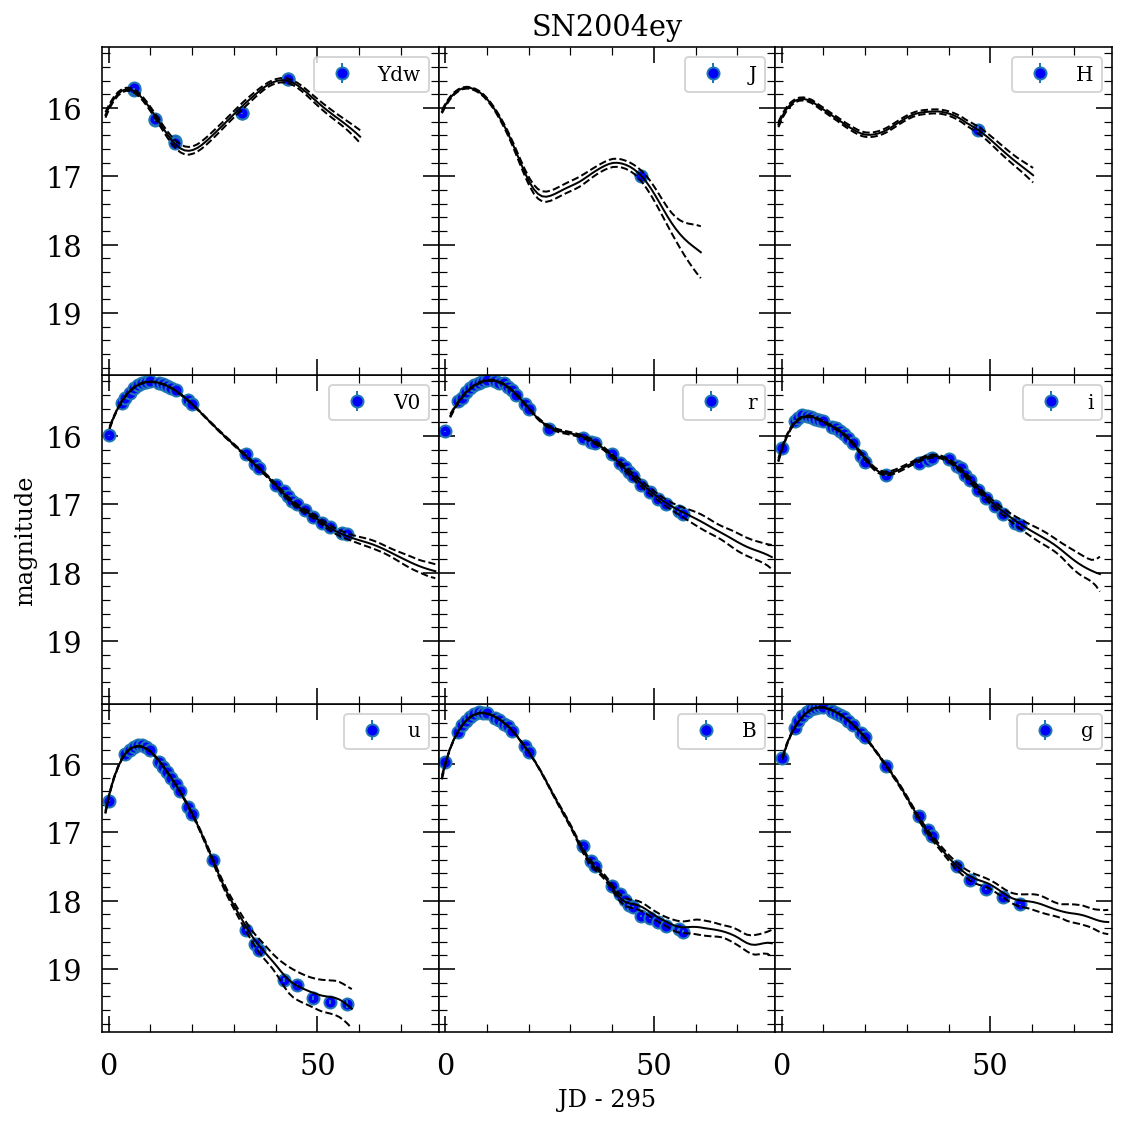

In [5]:
n_epochs = 1

sn_file = os.path.join('csp_dr3', 'SN2004ey_snpy.txt')
%time sn = snpy.import_lc(sn_file)

%time fit_combinatory(sn, n_epochs)

CPU times: user 1min 37s, sys: 1min 15s, total: 2min 52s
Wall time: 36.9 s
CPU times: user 4min, sys: 3min 1s, total: 7min 1s
Wall time: 1min 34s
CPU times: user 5min 17s, sys: 4min, total: 9min 17s
Wall time: 2min 3s


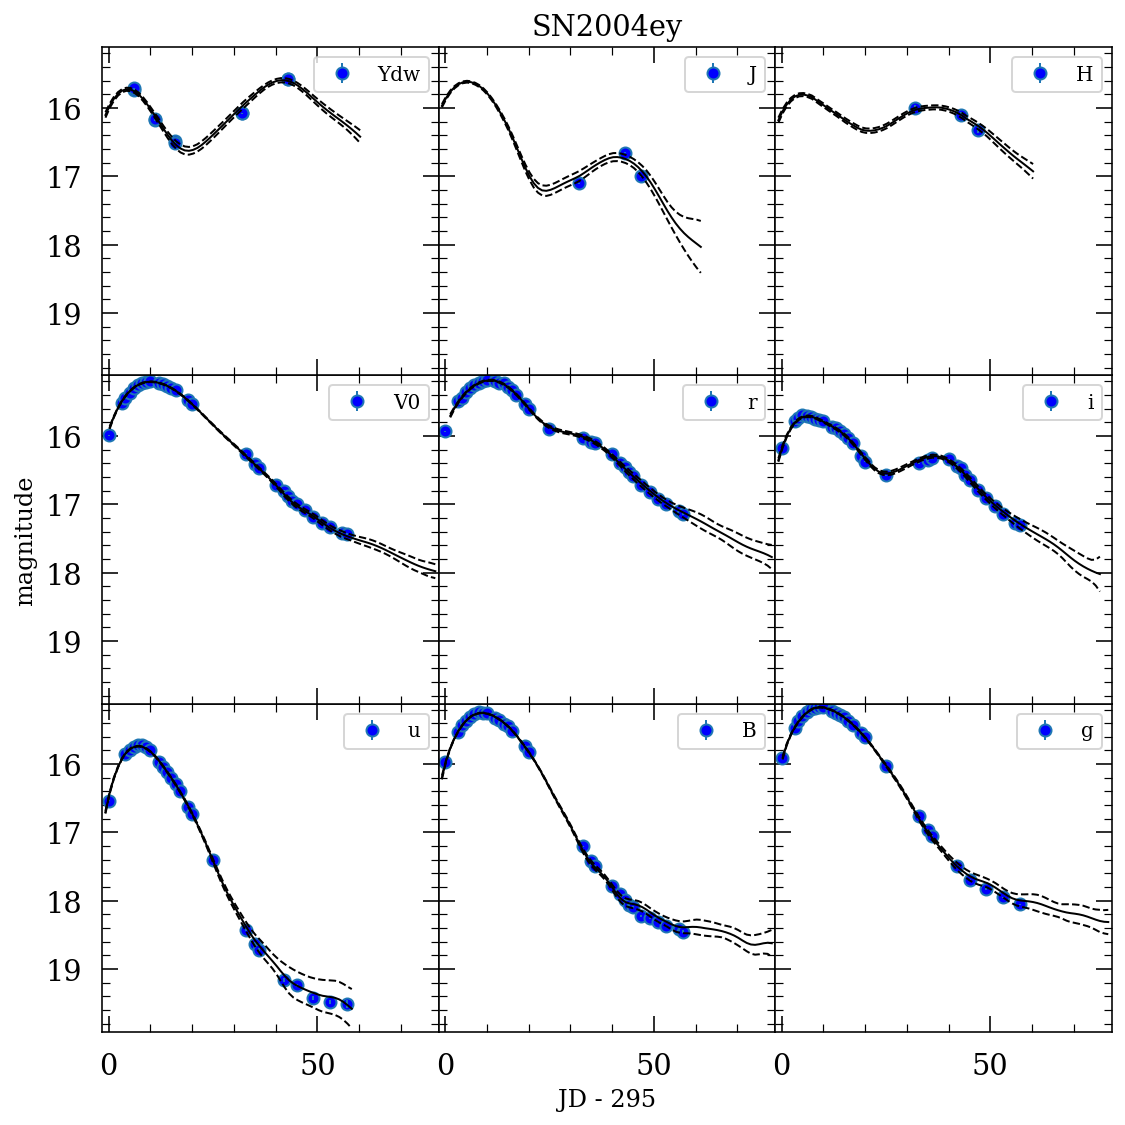

In [5]:
sn_file = os.path.join('csp_dr3', 'SN2004ey_snpy.txt')

for n_epochs in range(1, 4):
    sn = snpy.import_lc(sn_file)
    %time fit_combinatory(sn, n_epochs)

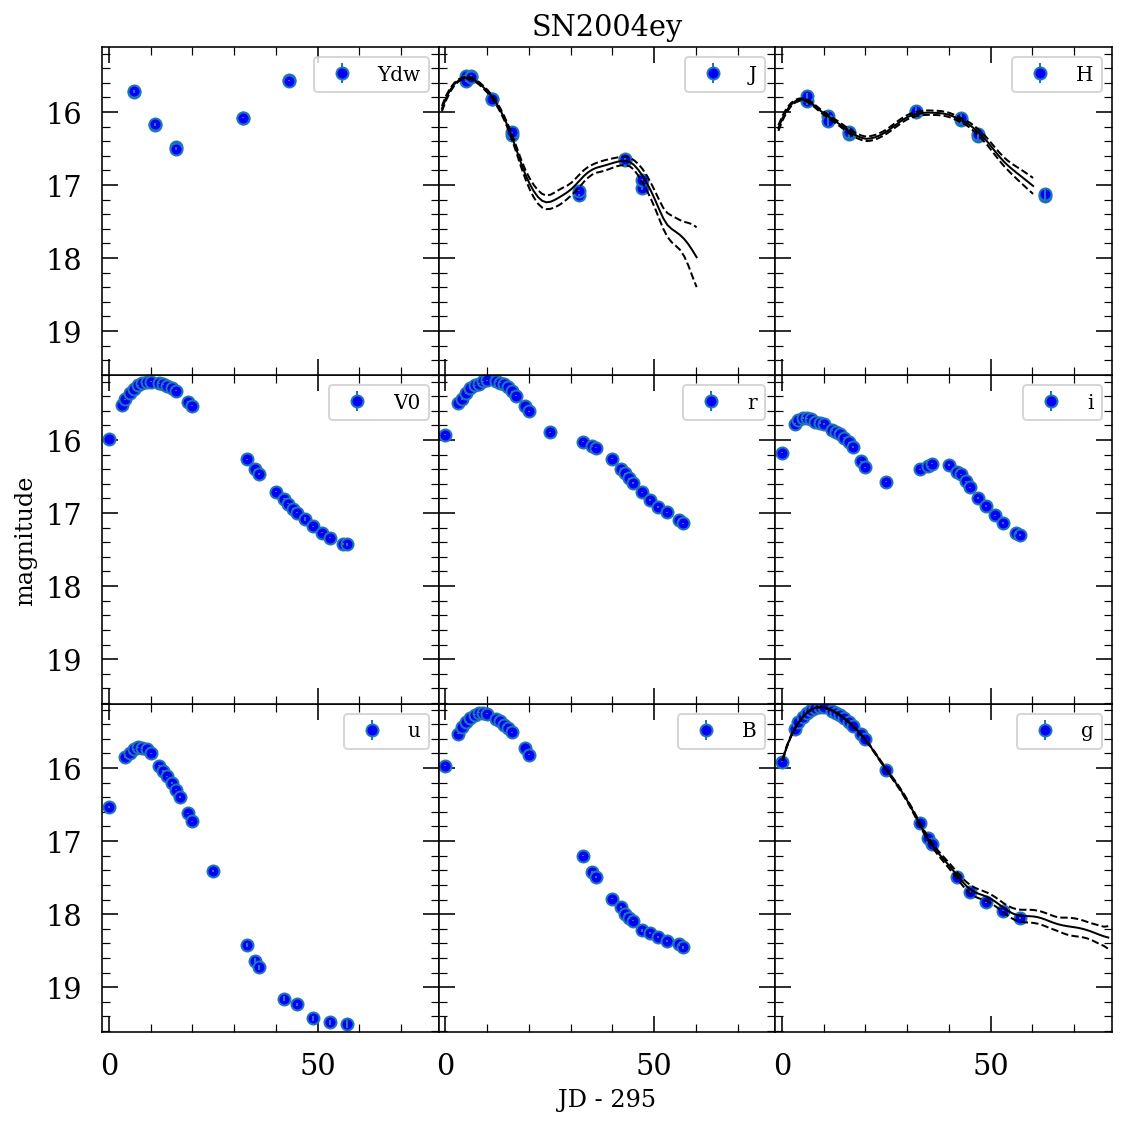

In [232]:
sn_file = os.path.join('csp_dr3', 'SN2004ey_snpy.txt')
sn = snpy.import_lc(sn_file)
sn.choose_model('max_model')
sn.fit(['g', 'J', 'H'])